# Crypto-Markowitz: Quantitative Portfolio Optimization

## 1. Project Overview
This project applies **Modern Portfolio Theory (MPT)**, developed by Nobel laureate Harry Markowitz, to the volatile world of cryptocurrencies. 

The goal is to move beyond "guessing" and use mathematical optimization to construct a portfolio that maximizes returns while minimizing risk (volatility). By analyzing the historical correlation between assets like **BTC, SOL, DOGE, and XRP**, we can find the "Efficient Frontier"—the set of optimal portfolios that offer the best possible return for every level of risk.

### Key Objectives:
* **Risk/Reward Visualization:** Map 1,000,000 simulated portfolios to visualize the risk-return trade-off.
* **Efficient Frontier Identification:** Use Monte Carlo simulations to find the mathematical boundary of optimal investment.
* **Constraint-Based Allocation:** Implement a 40% concentration limit to ensure true diversification and guard against "black swan" events in any single asset.

## 2. Environment Setup & Dependencies

To execute this quantitative analysis, we utilize four specialized libraries. Each plays a distinct role in the pipeline from data extraction to statistical modeling.

### Technical Stack:
* **`yfinance`**: Automates the retrieval of historical OHLC (Open, High, Low, Close) price data.
* **`numpy`**: Powers the high-speed matrix math required for our 1M portfolio simulations.
* **`pandas`**: Manages our time-series dataframes and daily return calculations.
* **`matplotlib`**: Renders the final Efficient Frontier and the Risk-Return scatter plot.

In [19]:
# To fetch the crypto data from Yahoo Finance
%pip install yfinance 

# To handle the data tables (DataFrames)
%pip install pandas 

# To perform the heavy math and matrix multiplications
%pip install numpy 

# To create the actual Markowitz graph
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


## Module 1: Data Acquisition & Preprocessing

With our environment ready, we fetch the historical data for our chosen assets. We focus exclusively on the **Adjusted Close Price**, as it provides the most accurate representation of value over time.

### The Workflow:
1. **Ticker Selection**: Define the specific cryptocurrencies for the portfolio (e.g., SOL, DOGE, BTC, XRP).
2. **Download**: Pull historical time-series data using the Yahoo Finance API.
3. **Filtering**: Extract only the `Close` column to simplify the mathematical operations in the following modules.

In [21]:
criptos = ['BTC-USD', 'XRP-USD', 'DOGE-USD', 'SOL-USD']
start_date = '2020-01-01'
end_date = '2025-12-31'
data = yf.download(criptos, start=start_date, end=end_date)['Close']
data.head()


[*********************100%***********************]  4 of 4 completed


Ticker,BTC-USD,DOGE-USD,SOL-USD,XRP-USD
Date,,,,
2020-01-01,7200.174316,0.002033,NaN,0.192667
2020-01-02,6985.470215,0.002009,NaN,0.188043
2020-01-03,7344.884277,0.002145,NaN,0.193521
2020-01-04,7410.656738,0.002241,NaN,0.194355
2020-01-05,7411.317383,0.002419,NaN,0.195537


## Module 2: Daily Returns Calculation

In portfolio theory, we analyze **percentage changes** rather than raw prices. This allows us to compare assets of different values (e.g., BTC at $100k vs. DOGE at $0.40) on a level playing field.

### The Logic:
We use the `.pct_change()` function to calculate the daily return for each token.

* **Formula:** $\text{Return} = \frac{\text{Price}_{\text{today}} - \text{Price}_{\text{yesterday}}}{\text{Price}_{\text{yesterday}}}$
* **Cleaning:** The first row of the data becomes a `NaN` (Not a Number) because there is no "yesterday" for the very first day. We use `.dropna()` to remove this empty row and keep our dataset clean.

In [22]:
# Formula: (Price_today / Price_yesterday) - 1
returns = data.pct_change().dropna()

print(returns.head())


Ticker       BTC-USD  DOGE-USD   SOL-USD   XRP-USD
Date                                              
2020-04-11 -0.000934  0.011179 -0.183202  0.003195
2020-04-12  0.016330  0.000000  0.136052  0.011018
2020-04-13 -0.018082 -0.015578 -0.118611 -0.012638
2020-04-14 -0.000381  0.002552 -0.149013 -0.012768
2020-04-15 -0.029276 -0.012220 -0.023075 -0.021933


## Module 3: Statistical Foundations (Mean & Covariance)

To build our optimization model, we must distill the historical data into two primary metrics that represent the "Engine" of Markowitz Theory.

### 1. Mean Returns (The Reward)
This represents the **Expected Return** of each asset. In our code, we calculate the average daily return and annualize it (multiplying by 252 trading days).
* **Concept:** If you held this asset for a year, what would be your "average" gain based on history?

### 2. Covariance Matrix (The Interaction)
This is the most critical part of diversification. Covariance measures how two assets move in relation to each other.
* **Positive Covariance:** The assets move together (e.g., BTC and ETH). This provides less protection during a crash.
* **Negative/Low Covariance:** The assets move independently or in opposite directions. This is the "Holy Grail" of diversification, as one asset's gain can offset another's loss.



### Why we need both:
Markowitz discovered that a portfolio's total risk is **not** just the average risk of its parts. It depends heavily on the **Covariance**. By mixing assets that don't move in perfect sync, we can actually lower the total portfolio risk without necessarily lowering the total return.

In [23]:
# Average daily return for each token
mean_returns = returns.mean()
print("Mean Returns:\n", mean_returns, "\n")

# Covariance matrix (The risk relationship between tokens)
cov_matrix = returns.cov()
print("Covariance Matrix:\n", cov_matrix, "\n")


Mean Returns:
 Ticker
BTC-USD     0.001686
DOGE-USD    0.004997
SOL-USD     0.004385
XRP-USD     0.002537
dtype: float64 

Covariance Matrix:
 Ticker     BTC-USD  DOGE-USD   SOL-USD   XRP-USD
Ticker                                          
BTC-USD   0.000927  0.001203  0.001046  0.000907
DOGE-USD  0.001203  0.010574  0.001610  0.001515
SOL-USD   0.001046  0.001610  0.004144  0.001582
XRP-USD   0.000907  0.001515  0.001582  0.003044 



## Module 4: Modern Portfolio Theory (MPT) Math

Now that we have the historical data, we need to calculate the performance of a hypothetical portfolio. We use two primary formulas to determine if a specific mix of assets is "good" or "bad."

### 1. Portfolio Expected Return ($R_p$)
This is the weighted average of the returns of the individual assets.
* **The Logic:** If you own 50% Bitcoin and it grows by 10%, it contributes 5% to your total portfolio return.
* **The Formula:**
$$R_p = \sum_{i=1}^{n} w_i \mu_i$$
* **Python Implementation:** `np.dot(weights, mean_returns) * 252`

### 2. Portfolio Risk / Volatility ($\sigma_p$)
Risk is not just the average of the individual volatilities. We must account for how assets move together (correlation) using the **Covariance Matrix** ($\Sigma$).
* **The Logic:** If one asset goes down while another stays stable, the total "swing" (risk) of your wallet is reduced. This is the "magic" of diversification.
* **The Formula:**
$$\sigma_p = \sqrt{w^T \Sigma w}$$
* **Python Implementation:** `np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))`

### 3. The Sharpe Ratio
This is the final "efficiency score." It tells us: *"For every 1% of risk I take, how much extra return am I earning?"*
* **The Formula:**
$$Sharpe = \frac{R_p - R_f}{\sigma_p}$$
*(Note: We often assume the Risk-Free Rate $R_f$ is 0 in crypto simulations for simplicity.)*

In [24]:
# Step A: Create 4 random weights that sum to 1
weights = np.random.random(len(criptos))
weights /= np.sum(weights)

# Step B: Calculate Annualized Return 
# (Daily Return * 252 trading days)
p_ret = np.dot(weights, mean_returns) * 252

# Step C: Calculate Annualized Volatility (Risk)
# Formula: sqrt(Weights * Covariance * Weights) * sqrt(252)
p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

print(f"Random Weights: {weights}")
print(f"Expected Annual Return: {p_ret:.2%}")
print(f"Expected Annual Risk: {p_vol:.2%}")


Random Weights: [0.03664515 0.49255572 0.35495872 0.11584041]
Expected Annual Return: 110.22%
Expected Annual Risk: 101.32%


## Module 5: The Monte Carlo Simulation

Since there are infinite ways to distribute our money across these 4 cryptos, we use a **Monte Carlo Simulation** to generate 1M random portfolios. This allows us to visualize the "Efficient Frontier."

### The Process:
1. **Randomize:** Assign a random weight to each asset.
2. **Normalize:** Ensure the sum of all weights equals 100% ($1.0$).
3. **Calculate:** Run the $R_p$ and $\sigma_p$ formulas for that specific mix.
4. **Record:** Store the results in arrays to plot them later.

By the end of this loop, we will have a "map" of the risk and return for 1M different investment strategies.

## Module 5.1: Adding Concentration Constraints

In this version of the simulation, we have implemented a **40% Concentration Limit**. 

### Why add constraints?
* **Forced Diversification:** Without this, the math often chooses a "corner solution" where 99% of the money goes into the single best-performing historical asset.
* **Risk Management:** By capping any single asset at 40%, we ensure the portfolio's survival even if one specific cryptocurrency faces a "black swan" event.

### How the loop changed:
We added a `while not valid_portfolio` loop. The script now generates random weights, checks if the highest weight is $\le 0.40$, and only "accepts" the portfolio if it meets our criteria. This "filters" the cloud to only show diversified options.

In [25]:
# 1. Initialization
num_portfolios = 1000000  # Note: 1M portfolios will take a few seconds
num_assets = len(criptos)

all_weights = np.zeros((num_portfolios, num_assets))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

# 2. The Simulation Loop
for i in range(num_portfolios):
    
    # Step A: Generate Random Weights that sum to 1 with 40% Concentration Limit
    valid_portfolio = False
    while not valid_portfolio:
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        # Applying the 40% Concentration Limit
        if np.max(weights) <= 0.40:
            valid_portfolio = True

    all_weights[i,:] = weights
    
    # Step B: Calculate Annualized Return (R_p)
    portfolio_return = np.dot(weights, mean_returns) * 252
    ret_arr[i] = portfolio_return
    
    # Step C: Calculate Annualized Volatility (sigma_p)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    vol_arr[i] = portfolio_volatility
    
    # Step D: Calculate Sharpe Ratio
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

# 3. FRONTIER CALCULATION ---
# Sorting results to find the "edge" of the cloud
idx = np.argsort(vol_arr)
vol_sorted = vol_arr[idx]
ret_sorted = ret_arr[idx]

frontier_vol = []
frontier_ret = []

max_ret = -np.inf
for v, r in zip(vol_sorted, ret_sorted):
    if r > max_ret:
        frontier_vol.append(v)
        frontier_ret.append(r)
        max_ret = r

print("Monte Carlo Simulation with 40% constraint complete.")


Monte Carlo Simulation with 40% constraint complete.


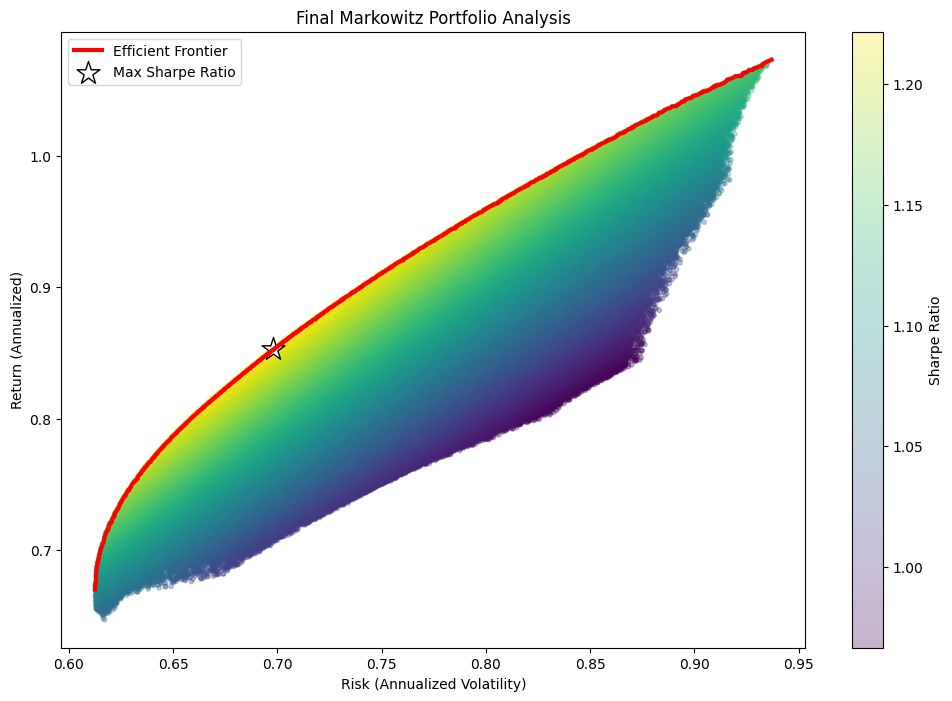

BTC-USD: 33.34%
XRP-USD: 15.93%
DOGE-USD: 40.00%
SOL-USD: 10.74%


In [26]:
plt.figure(figsize=(12, 8))

# 1. The Cloud (All portfolios)
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.3, s=10)
plt.colorbar(label='Sharpe Ratio')

# 2. The Frontier Line (The logic you just wrote!)
plt.plot(frontier_vol, frontier_ret, color='red', linewidth=3, label='Efficient Frontier')

# 3. The Optimal Point
max_sharpe_idx = sharpe_arr.argmax()
plt.scatter(vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx], color='white', marker='*', s=300, edgecolors='black', label='Max Sharpe Ratio')

plt.title('Final Markowitz Portfolio Analysis')
plt.xlabel('Risk (Annualized Volatility)')
plt.ylabel('Return (Annualized)')
plt.legend()
plt.show()

# Display the optimal weights
optimal_weights = all_weights[max_sharpe_idx]
for i, crypto in enumerate(criptos):
    print(f"{crypto}: {optimal_weights[i]:.2%}")